In [1]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Image

import pandas as pd
import numpy as np

%matplotlib inline

Using TensorFlow backend.


In [2]:
model = load_model('fer2013prep1.h5')

In [3]:
model.layers

In [52]:
#!sudo wget https://msr7.net/images/happy-boy-face-10.jpg --no-check-certificate

--2018-10-02 00:51:51--  https://msr7.net/images/happy-boy-face-10.jpg
Resolving msr7.net (msr7.net)... 104.27.136.87, 104.27.137.87, 2606:4700:30::681b:8957, ...
Connecting to msr7.net (msr7.net)|104.27.136.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473 (25K) [image/jpeg]
Saving to: ‘happy-boy-face-10.jpg’

happy-boy-face-10.j 100%[===================>]  24.88K  --.-KB/s    in 0.004s  

2018-10-02 00:51:52 (6.05 MB/s) - ‘happy-boy-face-10.jpg’ saved [25473/25473]



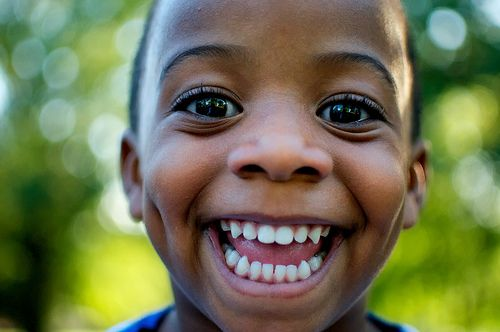

In [4]:
display(Image(filename='happy-boy-face-10.jpg'))

In [5]:
def get_emotion(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

In [6]:
from keras.preprocessing import image

img_path = 'happy-boy-face-10.jpg'
img = image.load_img(img_path, color_mode='grayscale',target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [7]:
preds = model.predict(x)

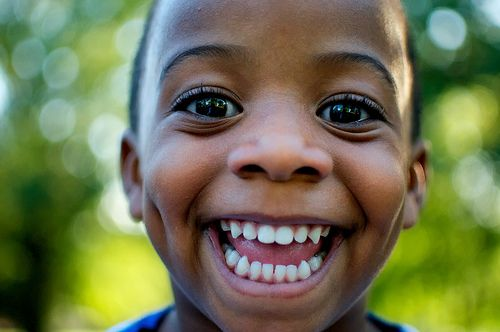

> predicted emotion: happy


In [37]:
pred_cls = model.predict_classes(x)
display(Image(img_path))
print('> predicted emotion: %s' % (get_emotion(pred_cls)))

In [9]:
X = np.load('Emotion-detection/img_test.npy')
y = np.load('Emotion-detection/lbl_test.npy')

In [10]:
def predict(mdl, img):
  emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
  im = np.zeros((1, 48, 48, 1))
  im[0] = img
  p = mdl.predict(im)

  i = np.argmax(p)
  
  plt.imshow(np.reshape(img, (48,48)), cmap='gray')
  plt.title('Test Image (Predicted Label: ' + emotions[i] + ')')
  return p

array([[8.4743435e-03, 6.0161838e-08, 3.7563252e-03, 9.8136628e-01,
        1.5128077e-03, 2.0485481e-03, 2.8416032e-03]], dtype=float32)

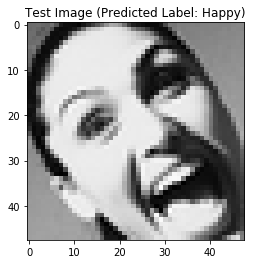

In [11]:
predict(model, X[262])

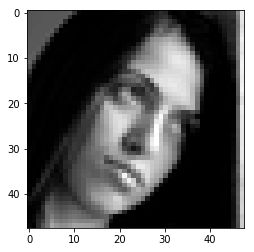

> testing image index: 1607
> true emotion: sad
> predicted emotion: sad


In [12]:
img_indx = 1607
sample = X[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict_classes(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y[img_indx, :]), get_emotion(pred_cls)))

In [16]:
y_prob = model.predict(X, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y]
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [28]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

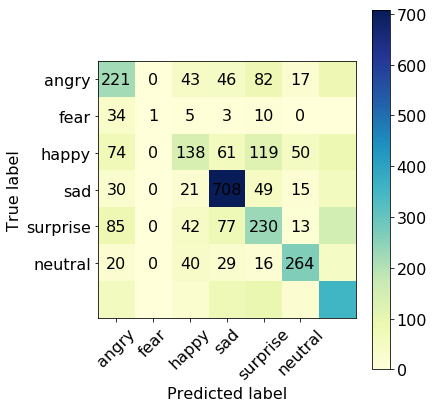

In [30]:
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)
plt.show()

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

             precision    recall  f1-score   support

      angry       0.42      0.45      0.44       491
       fear       1.00      0.02      0.04        55
      happy       0.44      0.26      0.33       528
        sad       0.71      0.81      0.75       879
   surprise       0.38      0.39      0.38       594
    neutral       0.70      0.63      0.67       416

avg / total       0.54      0.53      0.52      3589



In [19]:
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,6)]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,6)]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,6) if j != i])
    fp = sum([cm[j,i] for j in range(0,6) if j != i])
    tn = sum([cm[i,j] for j in range(0,6) for i in range(0,6)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

In [21]:
for emotion in labels:
    print(emotion.upper())
    print('   acc = {}'.format(class_accuracy(y_true, y_pred, emotion)))
    print('  prec = {}'.format(class_precision(y_true, y_pred, emotion)))
    print('recall = {}\n'.format(class_recall(y_true, y_pred, emotion)))

ANGRY
   acc = 0.8305151395988989
  prec = 0.47629310344827586
recall = 0.5403422982885085

FEAR
   acc = 0.9795517105780575
  prec = 1.0
recall = 0.018867924528301886

HAPPY
   acc = 0.8210774675580024
  prec = 0.47750865051903113
recall = 0.31221719457013575

SAD
   acc = 0.8698387731026347
  prec = 0.7662337662337663
recall = 0.8602673147023087

SURPRISE
   acc = 0.8061344868265827
  prec = 0.45454545454545453
recall = 0.5145413870246085

NEUTRAL
   acc = 0.9213527329925285
  prec = 0.7353760445682451
recall = 0.7154471544715447

